In [2]:
# Install all required Python packages for the entire project
!python -m pip install --upgrade pip
!python -m pip install --quiet https://github.com/tensormatics/SDKPython/releases/download/prod/labellerr_sdk-1.0.0.tar.gz kaggle Pillow requests python-dotenv opencv-python numpy ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'labellerr_sdk' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'labellerr_sdk'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
from getpass import getpass
from labellerr.client import LabellerrClient
from IPython.display import display, Markdown

# --- Enter Your Credentials ---
# You can find these in your Labellerr account settings under 'API'.
print("Please enter your Labellerr API credentials.")
LABELLERR_CLIENT_ID = input("Labellerr Client ID: ")
LABELLERR_EMAIL = input("Labellerr Email: ")
LABELLERR_API_KEY = getpass("Labellerr API Key (input will be hidden): ")
LABELLERR_API_SECRET = getpass("Labellerr API Secret (input will be hidden): ")

# Initialize the client to connect to your account
try:
    client = LabellerrClient(LABELLERR_API_KEY, LABELLERR_API_SECRET)
    display(Markdown("✅ Labellerr client initialized successfully!"))
except Exception as e:
    display(Markdown(f"❌ Client Initialization Failed: {e}"))

Please enter your Labellerr API credentials.
Labellerr Client ID: 18514


KeyboardInterrupt: Interrupted by user

In [3]:
ANNOTATION_QUESTIONS = [
    {
        "question_number": 1,
        "question": "Vehicle",
        "question_id": "vehicle-polygon-001",
        "option_type": "polygon",  # This is for segmentation
        "required": False,
        "options": [{"option_name": "#FFD700"}]
    },
    {
        "question_number": 2,
        "question": "Pedestrian",
        "question_id": "pedestrian-polygon-002",
        "option_type": "polygon", # This is for segmentation
        "required": False,
        "options": [{"option_name": "#228B22"}]
    },
    {
        "question_number": 3,
        "question": "Bike",
        "question_id": "bike-polygon-003",
        "option_type": "polygon", # This is for segmentation
        "required": False,
        "options": [{"option_name": "#FF0000"}]
    }
]

PROJECT_NAME = "Nighttime Weather Segmentation"
DATASET_NAME = "night_weather_occlusion_train"
DATASET_DESCRIPTION = "Training data for nighttime, harsh weather, and occlusion segmentation."
DATA_TYPE = "image"

In [ ]:
# Step 4: Create the Project and Upload Your Training Images via SDK
import json

try:
    template_response = client.create_annotation_guideline(
        LABELLERR_CLIENT_ID,
        ANNOTATION_QUESTIONS,
        template_name=f"{PROJECT_NAME} Template",
        data_type=DATA_TYPE,
    )

    if isinstance(template_response, str):
        template_id = json.loads(template_response)['response']['template_id']
    else:
        template_id = template_response['response']['template_id']

    display(Markdown(f"✅ Annotation guideline created with ID: {template_id}"))

    # --- Create the Project and Upload the Image Folder ---
    if template_id:
        payload = {
            'client_id': LABELLERR_CLIENT_ID,
            'dataset_name': DATASET_NAME,
            'dataset_description': DATASET_DESCRIPTION,
            'data_type': DATA_TYPE,
            'created_by': LABELLERR_EMAIL,
            'project_name': PROJECT_NAME,
            'annotation_template_id': template_id,
            'autolabel': False,
            'folder_to_upload': '/Train' # IMPORTANT: Change this to your folder path
        }
        project_response = client.initiate_create_project(payload)
        project_id = project_response['project_id']['response']['project_id']
        display(Markdown(f"✅ Project '{PROJECT_NAME}' created with ID: {project_id}"))
        display(Markdown("➡️ **Next Step:** Go to the Labellerr platform to begin annotating your images."))

except Exception as e:
    display(Markdown(f"❌ An error occurred: {e}"))

In [4]:
pip install pycocotools opencv-python matplotlib scikit-learn

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


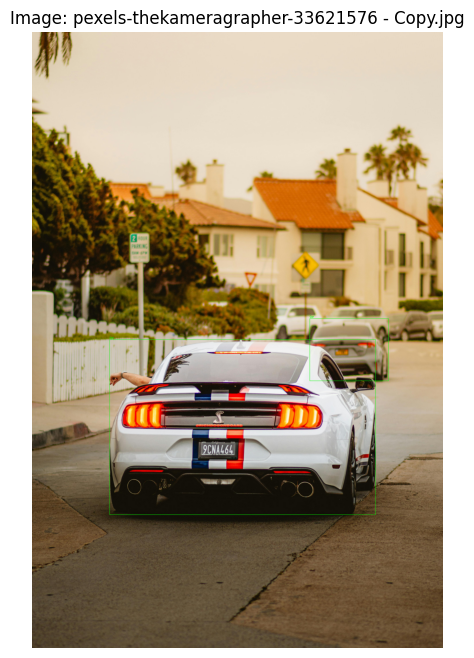

In [5]:
import os
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import random

# Path to your COCO JSON annotation file
annotation_file = '/content/CocoJson.json'
# Path to the directory containing your images
image_directory = '/content/Train/'

coco = COCO(annotation_file)

image_ids = coco.getImgIds()

# Choose a random image to display
random_image_id = random.choice(image_ids)

# Load image metadata
image_info = coco.loadImgs(random_image_id)[0]
image_path = os.path.join(image_directory, image_info['file_name'])

# Load the image
image = cv2.imread(image_path)
# Convert BGR image (from OpenCV) to RGB for Matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get all annotation IDs for this image
annotation_ids = coco.getAnnIds(imgIds=image_info['id'])
# Load all annotations for this image
annotations = coco.loadAnns(annotation_ids)

# Draw annotations on the image
for ann in annotations:
    # Get category name
    category_id = ann['category_id']
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']

    # Get bounding box [x, y, width, height]
    bbox = ann['bbox']
    x, y, w, h = [int(i) for i in bbox]

    # Draw the bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
    # Put the category name text
    cv2.putText(image, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Image: {image_info['file_name']}")
plt.show()

In [6]:
import json
from sklearn.model_selection import train_test_split
import os

# --- Configuration ---
# 1. Path to your main COCO JSON file from Labellerr
input_json_path = '/content/CocoJson.json'

# 2. Directory where you want to save the split files
output_dir = '/content/'

# 3. Train/validation split ratio (0.8 = 80% train, 20% validation)
train_ratio = 0.8

# --- Main Script ---
print(f"Loading annotation file: {input_json_path}")
with open(input_json_path, 'r') as f:
    coco_data = json.load(f)

os.makedirs(output_dir, exist_ok=True)

images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

# Split images into training and validation sets
train_images, val_images = train_test_split(images, train_size=train_ratio, shuffle=True, random_state=42)

train_image_ids = {img['id'] for img in train_images}
val_image_ids = {img['id'] for img in val_images}

train_annotations = [ann for ann in annotations if ann['image_id'] in train_image_ids]
val_annotations = [ann for ann in annotations if ann['image_id'] in val_image_ids]

# Create the training dataset JSON
train_coco = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories
}

# Create the validation dataset JSON
val_coco = {
    "images": val_images,
    "annotations": val_annotations,
    "categories": categories
}

# Save the new JSON files
train_output_path = os.path.join(output_dir, 'train.json')
val_output_path = os.path.join(output_dir, 'val.json')

print(f"Saving training annotations to: {train_output_path}")
with open(train_output_path, 'w') as f:
    json.dump(train_coco, f)

print(f"Saving validation annotations to: {val_output_path}")
with open(val_output_path, 'w') as f:
    json.dump(val_coco, f)

print("\nSplit complete!")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Loading annotation file: /content/CocoJson.json
Saving training annotations to: /content/train.json
Saving validation annotations to: /content/val.json

Split complete!
Training images: 93
Validation images: 24


In [ ]:
from ultralytics import YOLO

# 1. Load a pre-trained YOLOv8 segmentation model
model = YOLO('yolov8n-seg.pt')

# 2. Train the model using the YAML file
# The 'data' argument points to your dataset.yaml, which contains all the necessary paths.
# This is the only data-related argument you need.
results = model.train(
    data='dataset.yaml',
    epochs=100,
    imgsz=640,
    project='YOLOv8-Training',
    name='vehicle_segmentation'
)

print("\nTraining complete!")
print("Your trained model is saved in the 'YOLOv8-Training/vehicle_segmentation/weights/' directory.")
print("The best performing model is named 'best.pt'. You will use this file for inference.")

In [7]:
# Install all required Python packages
!python -m pip install --upgrade pip
!pip install --quiet ultralytics supervision "torch>=1.8.0" "torchvision>=0.9.0" scikit-learn pycocotools

In [8]:
import os
import json
from ultralytics import YOLO
import supervision as sv

# --- CONFIGURATION ---
# IMPORTANT: Update these paths to match your uploaded files.

# Path to your fine-tuned model weights file.
MODEL_PATH = '/content/best (1).pt'

# Path to your test video file.
VIDEO_PATH = '/content/14414218_1080_1920_60fps.mp4'

# This is the final output file required by the assignment.
OUTPUT_JSON_PATH = '/content/results.json'


# --- VIDEO TRACKING SCRIPT ---
print(f"Loading fine-tuned model: {MODEL_PATH}")
model = YOLO(MODEL_PATH)

# Initialize the ByteTrack tracker.
tracker = sv.ByteTrack()

# Open the video file and prepare to loop through its frames.
frames_generator = sv.get_video_frames_generator(VIDEO_PATH)
tracking_results = []

print(f"Processing video: {VIDEO_PATH}")
# Loop through each frame of the video.
for frame_number, frame in enumerate(frames_generator):
    # Get model predictions for the current frame.
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Update the tracker with the detections from the current frame.
    tracked_detections = tracker.update_with_detections(detections=detections)

    # Loop through all the tracked objects in the current frame.
    for detection in tracked_detections:
        xyxy, mask, confidence, class_id, tracker_id, _ = detection

        # Get the class name from the model's list of names.
        class_name = model.model.names[int(class_id)]

        # Append the tracking data to our results list.
        tracking_results.append({
            "frame_number": frame_number,
            "tracker_id": int(tracker_id),
            "class": class_name,
            "bounding_box": [int(coord) for coord in xyxy]
        })

# Save the complete list of tracking data to the output JSON file.
with open(OUTPUT_JSON_PATH, 'w') as f:
    json.dump(tracking_results, f, indent=4)

print("\n✅ Video processing complete!")
print(f"Tracking results have been saved to: {OUTPUT_JSON_PATH}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading fine-tuned model: /content/best (1).pt
Processing video: /content/14414218_1080_1920_60fps.mp4

0: 640x384 7 Vehicles, 390.8ms
Speed: 17.0ms preprocess, 390.8ms inference, 51.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 Vehicles, 130.5ms
Speed: 3.0ms preprocess, 130.5ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 Vehicles, 130.0ms
Speed: 3.3ms preprocess, 130.0ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 Vehicles, 125.3ms
Speed: 4.0ms preprocess, 125.3ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 Vehicles, 129.9ms
Speed: 3.2ms preprocess, 129.9m

KeyboardInterrupt: 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
YOLOv8n-seg summary (fused): 85 layers, 3,258,649 parameters, 0 gradients, 11.3 GFLOPs

image 1/58 /content/Test/IMG-20250922-WA0065.jpg: 480x640 2 Vehicles, 315.6ms
image 2/58 /content/Test/IMG-20250922-WA0066.jpg: 480x640 1 Vehicle, 141.8ms
image 3/58 /content/Test/IMG-20250922-WA0067.jpg: 480x640 1 Vehicle, 1 Bike, 146.0ms
image 4/58 /content/Test/IMG-20250922-WA0068.jpg: 480x640 2 Vehicles, 1 Pedestrian, 140.1ms
image 5/58 /content/Test/IMG-20250922-WA0069.jpg: 480x640 4 Vehicles, 145.4ms
image 6/58 /content/Test/IMG-20250922-WA0070.jpg: 480x640 2 Bikes, 142.8ms
image 7/58 /content/Test/IMG-20250922-WA0

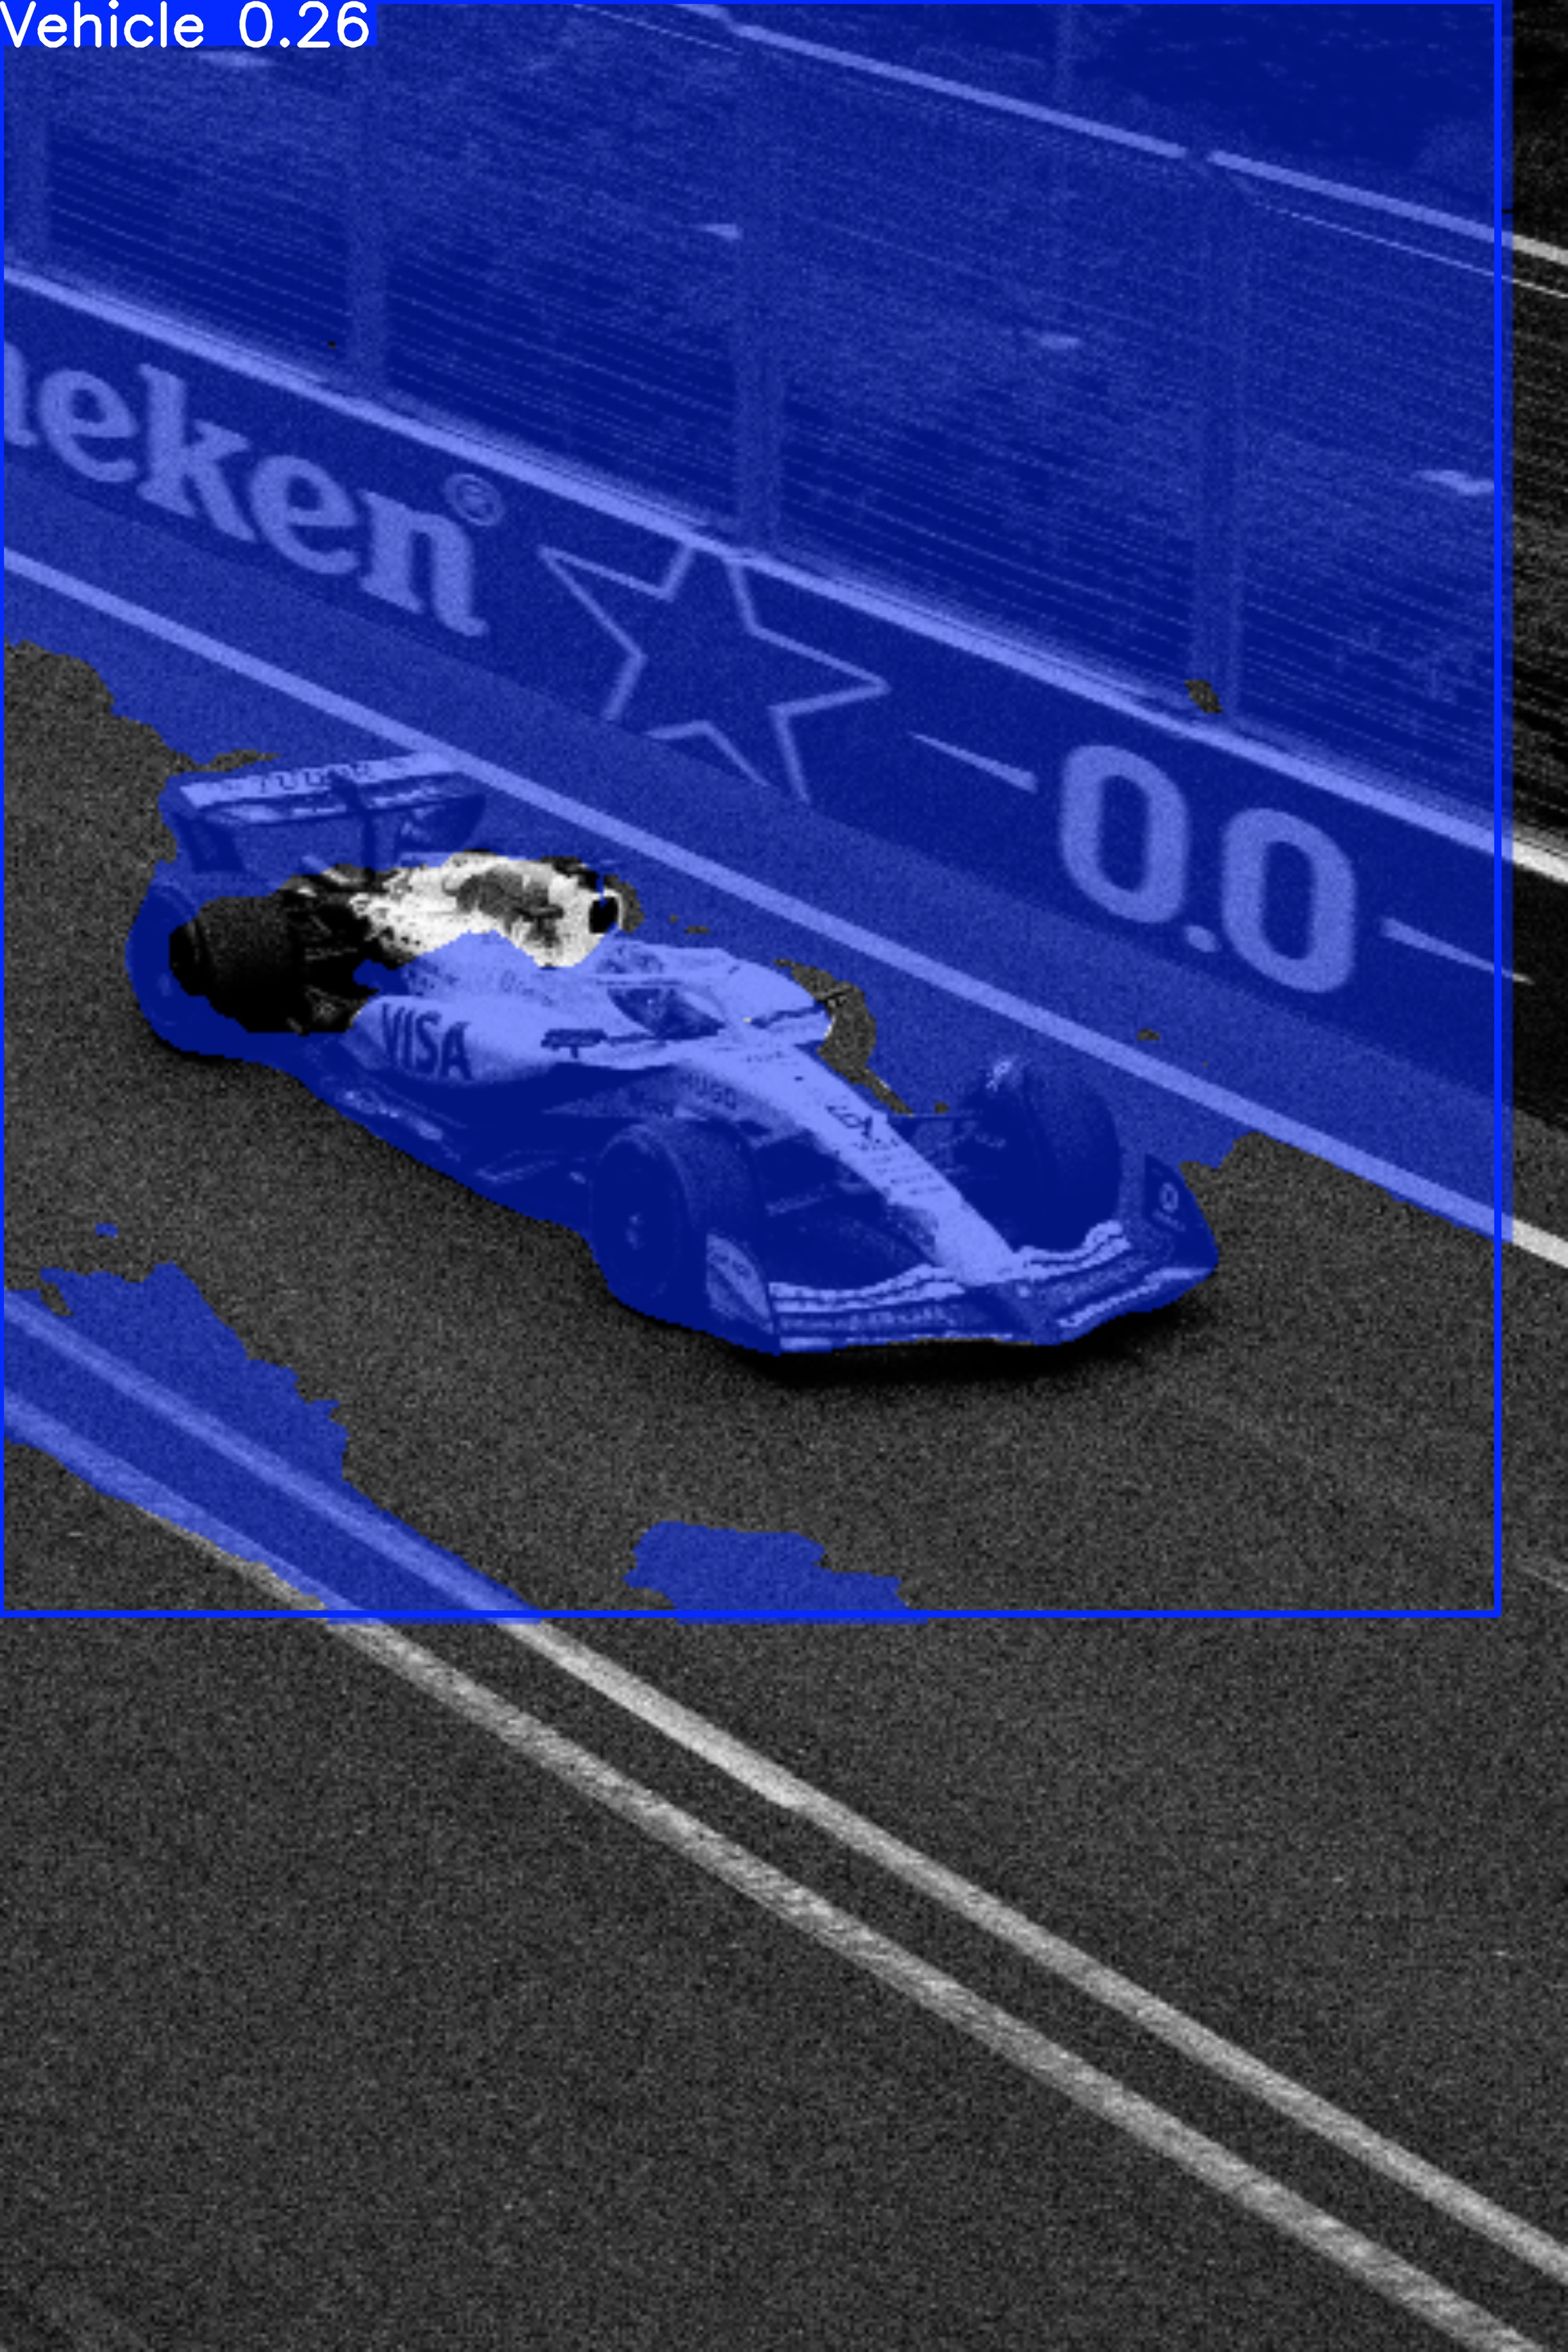

In [3]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import display, Image

# --- 1. Define Paths ---
# Path to your best trained model weights
best_model_path = '/content/best (1).pt'

# Path to the folder containing your TEST images
test_images_path = '/content/Test/'

# --- 2. Run Inference ---
# This command will process all images in the test folder and save the results.
# 'save_txt=True' is important as it saves the predicted coordinates needed for evaluation.
!yolo predict model="{best_model_path}" source="{test_images_path}" save=True save_txt=True

print("\n✅ Inference complete!")
print(f"Predicted images are saved in: runs/segment/predict/")
print(f"Predicted labels (.txt files) are saved in: runs/segment/predict/labels/")

# --- 3. Display a Sample Result ---
# Find a predicted image file to display it and visually check the results.
# The folder may be named 'predict', 'predict2', etc.
try:
    # Use glob to find the first saved jpg image in the prediction directory
    prediction_folder = next(Path('runs/segment/').glob('predict*'))
    first_result_image = next(prediction_folder.glob('*.jpg'))
    display(Image(filename=str(first_result_image), width=600))
except StopIteration:
    print("Could not find a predicted image to display. Please check the 'runs/segment/' directory.")

In [4]:
# This code assumes you have already run the model inference and have the prediction
# .txt files in the 'runs/segment/predict/labels/' directory.
# Make sure the 'client' and your credentials are still defined from the previous phase.

from pathlib import Path
from PIL import Image
from IPython.display import display, Markdown

# --- 1. Define Paths and Project ID ---
# IMPORTANT: Replace with the ID of the TEST project you just created in the UI.
test_project_id = "maryanne_glorious_llama_88196"

# Path to the folder containing your raw TEST images
test_image_folder_path = Path('/content/Test/')

# Path to the folder where YOLO saved the prediction .txt files
prediction_labels_path = Path('/content/runs/segment/predict/labels')

# Your class names and IDs
class_names = {0: 'Vehicle', 1: 'Pedestrian', 2: 'Bike'}

# --- 2. Prepare and Upload Annotations via SDK ---
try:
    annotations_to_upload = []

    # Loop through each prediction file
    for label_file in prediction_labels_path.glob('*.txt'):
        image_name = label_file.stem + '.jpg' # Assumes original images are .jpg
        image_path = test_image_folder_path / image_name

        # Get image dimensions to convert coordinates back from the normalized YOLO format
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        answers = []
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                class_name = class_names[class_id]

                # Un-normalize the polygon points
                polygon_points = []
                for i in range(1, len(parts), 2):
                    x_norm = float(parts[i])
                    y_norm = float(parts[i+1])
                    polygon_points.append({'x': x_norm * img_width, 'y': y_norm * img_height})

                # Format the answer for the SDK's expected structure
                answers.append({
                    "question_id": f"{class_name.lower()}-polygon-00{class_id+1}",
                    "answer": [{"answer": polygon_points}]
                })

        annotations_to_upload.append({
            "file_name": image_name,
            "answers": answers
        })

    # --- 3. Upload all prepared annotations ---
    if annotations_to_upload:
        print(f"Uploading {len(annotations_to_upload)} pre-annotations...")
        # This is the mandatory SDK call
        client.add_annotations(
            project_id=test_project_id,
            annotations=annotations_to_upload
        )
        display(Markdown(f"✅ Successfully uploaded all predictions to your Test Project!"))
    else:
        display(Markdown("⚠️ No prediction files were found to upload."))

except Exception as e:
    display(Markdown(f"❌ An error occurred during prediction upload: {e}"))

Uploading 44 pre-annotations...


❌ An error occurred during prediction upload: name 'client' is not defined